# Introduction
In this notebook, we are going to solve a simple optimal growth model with one agent. The model is a simplified version of Brock and Mirman (1972). The planner aims to maximize his time-separable life time utility subject to his budget constraint:
$$
\begin{align}
&\max_{\left\{c_{t}\right\}_{t=0}^{\infty}} \sum_{t=0}^{\infty} \beta^{t} \ln\left(c_{t}\right) \\
\text{s.t.} \quad & k_{t+1} + c_{t} \leq Ak_{t}^\alpha
\end{align}
$$
As is well known, this particular problem has an analytical (or closed-form) solution:
$$
\begin{align}
k_{t+1} = \beta \alpha A k_{t}^{\alpha}
\end{align}
$$
At first, we want to check the optimal growth path by applying the above policy function.

In [1]:
# Import necessary liblaries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline
print("Version of tensorflow is {}".format(tf.__version__))

/home/takafumi/.pyenv/versions/anaconda3-5.3.1/envs/tensor1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/takafumi/.pyenv/versions/anaconda3-5.3.1/envs/tensor1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/takafumi/.pyenv/versions/anaconda3-5.3.1/envs/tensor1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtyp

Version of tensorflow is 1.13.1


In [2]:
A = 1  # Technology level
alpha = 0.3  # Capital share in the Cobb-Douglas production function
beta = 0.95  # Discount factor

def k_plus_analytic(k, alpha, beta, A):
    "Return the optimal capital stock in the next period"
    return alpha * beta * A * k**alpha

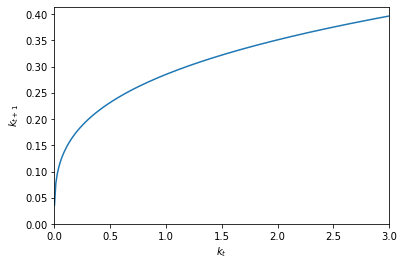

In [3]:
# Setup the capital grid
kbeg, kend, ksize = 1e-3, 3, 250
kgrid = np.linspace(kbeg, kend, ksize)

k_plus = k_plus_analytic(kgrid, alpha, beta, A)

plt.plot(kgrid, k_plus)
plt.xlim(0, kend)
plt.ylim(0, None)
plt.xlabel(r"$k_{t}$")
plt.ylabel(r"$k_{t+1}$")
plt.show()

# Deep neural net
## The network architecture
Now, we aim to solve the Brock and Mirman (1972) by using deep learning following Azinovic et al. (2019). When we solve the above model for the first-order condition, we can derive the following two equilibrium conditions:
$$
\begin{align}
& \lambda_{t} - \beta \lambda_{t+1} A \alpha k_{t+1}^{\alpha - 1} = 0 \\
& \left[A k_{t}^{\alpha} - k_{t+1} - \frac{1}{\lambda_{t}}\right]\lambda_{t} = 0
\end{align}
$$

Here, we build the neural net. The neural network is assumed to have the following archtecture:  
Layer 1: the input layer, 1 neuron corresponding to the capital stock today  
Layer 2: the first hidden layer, 50 neurons and is activated by Relu  
Layer 3: the second hidden layer, 50 neurons and is activated by Relu  
Layer 4: the output layer, 2 neurons corresponding to the capital stock tomorrow and the Lagrange multiplier

In [4]:
num_input = 1
num_hidden1 = 50
num_hidden2 = 50
num_output = 2

layers_dim = [num_input, num_hidden1, num_hidden2, num_output]
print("Dimensions of each layer are {}".format(layers_dim))

Dimensions of each layer are [1, 50, 50, 2]


In [5]:
def create_placeholders(num_x):
    """ Create the placeholders.
    The row dimention is None that represents the length of the simulated 
    path."""
    X = tf.placeholder(tf.float32, shape=[num_x, None], name='X')
    return X

def initialize_parameters(layers_dim):
    """ Initialize parameters to build a neural network
    1: [num_x, None] -> [num_hidden1, None] 
    2: [num_hidden1, None] -> [num_hidden2, None] 
    3: [num_hidden2, None] -> [2, None] 
    """

    W1 = tf.get_variable('W1', [layers_dim[1], layers_dim[0]], tf.float32,
                         tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable('b1', [layers_dim[1], 1], tf.float32, 
                         tf.zeros_initializer())
    W2 = tf.get_variable('W2', [layers_dim[2], layers_dim[1]], tf.float32,
                         tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable('b2', [layers_dim[2], 1], tf.float32,
                         tf.zeros_initializer())
    W3 = tf.get_variable('W3', [layers_dim[3], layers_dim[2]], tf.float32,
                         tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable('b3', [layers_dim[3], 1], tf.float32, 
                         tf.zeros_initializer())

    parameters = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    return parameters

# -------------------------------------------------------------------------- #
# Test
# -------------------------------------------------------------------------- #
# with tf.Session() as sess:
    # tf.reset_default_graph()
    # X = create_placeholders(num_input)
    # print("X = {}".format(X))
    # parameters = initialize_parameters(layers_dim)
    # print(parameters)

Next, we define the architecture of the neural network. We assumed that:
The first layer converts [None, num_input] to [None, num_hidden1] and activates it via Relu.
The second layer converts [None, num_hidden1] to [None, num_hidden2] and activates it via Relu.
The third layer converts [None, num_hidden2] to [None, 2] and activates it via Softplus.

In [6]:
def forward_propagation(X, parameters):
    """ Implement the forward propagation for the model
    Linear -> RELU -> Linear -> RELU -> Linear -> Softplus """

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    print("Currnet X is {}".format(X))

    Z1 = tf.add(tf.matmul(W1, X), b1)  # Linear combination
    A1 = tf.nn.relu(Z1)  # Activate with Relu
    Z2 = tf.add(tf.matmul(W2, A1), b2)  # Linear combination
    A2 = tf.nn.relu(Z2)  # Activate with Relu
    Z3 = tf.add(tf.matmul(W3, A2), b3)  # Linear combination
    A3 = tf.nn.softplus(Z3)  # Activate with Relu

    return A3

# -------------------------------------------------------------------------- #
# Test
# -------------------------------------------------------------------------- #
# tf.reset_default_graph()
# with tf.Session() as sess:
    # X = create_placeholders(num_input)
    # parameters = initialize_parameters(layers_dim)
    # A3 = forward_propagation(X, parameters)
    # print(A3)

## Cost function
Cost function is the mean squared sum of the relative Euler error and the approximation error in the KKT condition.

In [7]:
def compute_cost(X, parameters, beta, A, alpha):
    
    # Current capital state
    k = X
    # print(k)
    
    # Retlieve the simulation path
    action = forward_propagation(X, parameters)
    # print(action)
    k_plus = tf.expand_dims(action[0, :], axis=0)
    lambd = tf.expand_dims(action[1, :], axis=0)
    # print(action, k_plus, lambd)
    
    # Retlieve the optimal actions in the next period
    action_plus = forward_propagation(k_plus, parameters)
    k_plusplus = tf.expand_dims(action_plus[0, :], axis=0)
    lambd_plus = tf.expand_dims(action_plus[1, :], axis=0)
    
    # Define the relative Euler error
    errREE = (beta * lambd_plus * A * alpha * k_plus**(alpha-1)) / lambd - 1
    print("errREE has {}".format(errREE[:]))
    # Define the KKT error
    errKKT = lambd * (A * k**alpha - k_plus - 1/lambd)
    print("errKKT has {}".format(errKKT))
    err = tf.stack([errREE[0], errKKT[0]])
    print(err)
    err_optimal = tf.zeros_like(err)
    
    # Define the cost function
    cost = tf.losses.mean_squared_error(err, err_optimal)
    
    return cost

# -------------------------------------------------------------------------- #
# Test
# -------------------------------------------------------------------------- #
# tf.reset_default_graph()
# with tf.Session() as sess:
    # X = create_placeholders(num_input)
    # parameters = initialize_parameters(layers_dim)
    # cost = compute_cost(X, parameters, beta, A, alpha)
    # print("cost = {}".format(cost))

Prepare a training dataset.

In [8]:
num_train = 100000
X_data_train = np.random.uniform(kbeg, kend, (num_input, num_train))
print(X_data_train)
print("X has a shape of {}".format(X_data_train.shape))

[[1.42199955 1.29417909 2.59049789 ... 2.9282587  1.17715067 0.42730446]]
X has a shape of (1, 100000)


Let the model learn.

In [9]:
def model(train_X, layers_dim, learning_rate, num_iters, print_cost=True):
    """ Train the DNN with the provided training data """

    tf.reset_default_graph()  # Reset DNN
    (num_input, t_length) = train_X.shape
    costs = []  # Keep track of the cost
    
    # Create placeholder
    X = create_placeholders(num_input)
    print(X)
    # Initialize parameters
    parameters = initialize_parameters(layers_dim)
    
    # One step of the forward propagation
    A3 = forward_propagation(X, parameters)
    # Compute the current cost
    cost = compute_cost(A3, parameters, beta, A, alpha)
    # Set the optimizer in the backward propagation
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(
        cost)
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # ---------------------------------------------------------------------- #
    # Start to train DNN
    # ---------------------------------------------------------------------- #   
    with tf.Session() as sess:
        sess.run(init)  # Initialization
        for i in range(1, num_iters+1):
            _, _cost = sess.run([optimizer, cost], feed_dict={X: train_X})
            costs.append(_cost)

            # Print the cost every epoch
            if print_cost is True and i % 100 == 0:
                print(r'Cost after iteration {} is {:5f}'.format(i, _cost))
                
        # Save the parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained")
        
        return costs, parameters

Train the DNN with the following set

In [10]:
learning_rate = 0.001
num_iters=10000

costs, parameters_star = model(
    X_data_train, layers_dim, learning_rate=learning_rate, 
    num_iters=num_iters, print_cost=True)

Tensor("X:0", shape=(1, ?), dtype=float32)

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Currnet X is Tensor("X:0", shape=(1, ?), dtype=float32)
Currnet X is Tensor("Softplus:0", shape=(2, ?), dtype=float32)


ValueError: Dimensions must be equal, but are 1 and 2 for 'MatMul_3' (op: 'MatMul') with input shapes: [50,1], [2,?].